# **IonQ** and **Vanderbilt Quantum Initiative** presents:

## FLIQ 2025 Challenge - *MAX-CUT: Ground State at Minimal Cost*



Welcome to a deep dive into quantum optimization with IonQ and Vanderbilt Quantum Initiative! First we'll showcase a powerful approach to solving the [Maximum Cut (MaxCut)][3] problem—a notorious [NP-hard][2] combinatorial optimization task. We'll be applying a [pioneering variational Quantum Imaginary Time Evolution (varQITE)][4] algorithm. This method is the fruit of a collaborative effort between IonQ's quantum experts and researchers at Oak Ridge National Labs (ORNL). Get ready to explore how quantum computing can offer new pathways to tackle computationally intensive problems!

[2]: https://en.wikipedia.org/wiki/NP-hardness
[3]: https://en.wikipedia.org/wiki/Maximum_cut
[4]: https://arxiv.org/pdf/2404.16135

## Deconstructing the Challenge: What is the Maximum Cut Problem?

### MaxCut Essentials: A Primer

The Maximum Cut Problem, or MaxCut, stands as a cornerstone in the world of combinatorial optimization. It's a classic that researchers frequently use to benchmark the performance of new algorithms, especially in scientific and high-performance computing. Beyond its academic significance, MaxCut has a surprisingly broad range of practical applications across numerous disciplines. For instance:

* In **Very Large Scale Integration (VLSI) circuit design**, MaxCut helps determine the most efficient layout for circuit components, minimizing interference and maximizing performance.
* Within the realm of **social network analysis**, it's instrumental in identifying distinct communities or clusters of interconnected individuals.
* In **computer vision**, MaxCut algorithms are employed for tasks like image segmentation, separating an image into meaningful regions.
* Its principles also extend to fields like **statistical physics** for analyzing spin glass models and **bioinformatics** for understanding protein interactions.

**At its heart, MaxCut is a graph partitioning problem.** Imagine you're given a graph, which is a collection of nodes (vertices) connected by lines (edges). Let's denote this graph as $G = (V, E)$, where $V$ is the set of all vertices and $E$ is the set of all edges. The MaxCut problem then asks a simple yet profound question: How can you divide all the vertices in $V$ into two distinct, non-overlapping groups (let's call them $S$ and $T$) in such a way that the number of edges "crossing" between these two groups is as large as possible? An edge is considered "crossing" if one of its endpoints is in set $S$ and the other is in set $T$.

Think of it like this: you have a network of points and connections. Your task is to draw a line that divides the points into two zones. You want to draw this line so that it severs the maximum number of connections. The more connections you cut, the better your solution to the MaxCut problem. This seemingly simple objective has profound implications for optimization and is a fantastic testbed for quantum algorithms.

# Prepare the code environment
First, we'll set up the coding environment and install necessary dependencies.

In [1]:
!pip install qiskit qiskit-aer networkx numpy pandas pylatexenc -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 4.5 MB/s eta 0:00:00


To ensure your code runs correctly everywhere, please only use the imported dependencies.  Using external libraries may cause your submission to fail due to missing dependencies on our servers.

In [2]:
## IonQ, Inc., Copyright (c) 2025,
# All rights reserved.
# Use in source and binary forms of this software, without modification,
# is permitted solely for the purpose of activities associated with the IonQ
# Hackathon at iQuHack2025 hosted by MIT and only during the Feb 1-2, 2025
# duration of such event.

import matplotlib.pyplot as plt
from IPython import display

import networkx as nx
import numpy as np
import pandas as pd
import time

from typing import List
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator

# Graph definition

A simple graph, defined using the Python NetworkX library, will serve to illustrate the problem and you can explore further complexities.


In [5]:
import networkx as nx
from networkx.generators.degree_seq import random_degree_sequence_graph
import matplotlib.pyplot as plt
import random
import math

def ring_mesh_8():
    G = nx.Graph()
    G.add_edges_from([(i, (i + 1) % 8) for i in range(8)])
    plt.figure(figsize=(6, 6))

    pos = {i: (math.cos(2 * math.pi * i / 8), math.sin(2 * math.pi * i / 8)) for i in range(8)}
    nx.draw(G, pos, with_labels=True, node_color='cyan', edge_color='black', node_size=450)
    plt.title("8-Node Ring Mesh")
    plt.show()
    return G

def bi_complete_8x8():
    left = list(range(8))
    right = list(range(8, 16))
    G = nx.Graph()
    G.add_nodes_from(left + right)

    for u in left:
        for v in right:
            G.add_edge(u, v)
    plt.figure(figsize=(8, 6))

    pos = {u: (0, 7 - u) for u in left}
    pos.update({v: (1, 15 - v) for v in right})
    colors = ['salmon'] * 8 + ['lightblue'] * 8
    nx.draw(G, pos, with_labels=True, node_color=colors, edge_color='gray', node_size=300)
    plt.title("Complete Bipartite 8×8")
    plt.show()
    return G

def bi_complete_nxn(n):
    left = list(range(n))
    right = list(range(n, 2 * n))
    G = nx.Graph()
    G.add_nodes_from(left + right)
    for u in left:
        for v in right:
            G.add_edge(u, v)
    plt.figure(figsize=(8, 6))
    pos = {u: (0, (n - 1) - u) for u in left}
    pos.update({v: (1, (2 * n - 1) - v) for v in right})
    colors = ['salmon'] * n + ['lightblue'] * n
    nx.draw(G, pos, with_labels=True, node_color=colors, edge_color='gray', node_size=300)
    plt.title(f"Complete Bipartite {n}×{n}")
    plt.show()
    return G

def reg_graph_8():
    seq = [4] * 8
    tries = 0
    while True:
        G = random_degree_sequence_graph(seq, seed=random.randint(0, 1000))

        if nx.is_connected(G) and all(d == 4 for _, d in G.degree()):
            break
        tries += 1
        if tries > 10:
            break
    plt.figure(figsize=(6, 6))
    pos = nx.circular_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightgreen', edge_color='gray', node_size=500)
    plt.title("4-Regular 8-Node via Degree-Sequence")
    plt.show()
    return G

def cubic_graph_16():
    G = nx.random_regular_graph(3, 16, seed=1234)
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, seed=24)
    nx.draw(G, pos, with_labels=True, node_color='lightcoral', edge_color='gray', node_size=300)
    plt.title("3-Regular 16-Node (Cubic) Variant")
    plt.show()
    return G

def random_connected_graph_16(p=0.18):
    n = 16
    tries = 0
    while True:
        G = nx.erdos_renyi_graph(n, p, seed=random.randint(0, 10000))
        if nx.is_connected(G):
            break
        tries += 1
        if tries > 20:
            break
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=99)
    nx.draw(G, pos, with_labels=False, node_color='lightgreen', edge_color='gray', node_size=100)
    plt.title(f"Random Connected 16-Node Graph (p={p})")
    plt.show()
    return G

def expander_graph_n(n):
    G = nx.random_regular_graph(4, n, seed=99)
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=30)
    nx.draw(G, pos, with_labels=False, node_color='lightblue', edge_color='gray', node_size=100)
    plt.title(f"Expander-Like {n}-Node 4-Regular Graph")
    plt.show()
    return G

def defective_grid_4x4():
    G = nx.Graph()
    G.add_nodes_from(range(16))

    for i in range(16):
        if i % 4 != 3 and not (i == 5):
            G.add_edge(i, i + 1)

    for i in range(12):
        G.add_edge(i, i + 4)
    plt.figure(figsize=(6, 6))
    pos = {i: (i % 4, -(i // 4)) for i in range(16)}
    nx.draw(G, pos, with_labels=True, node_color='orange', edge_color='gray', node_size=500)
    plt.title("4×4 Grid with Missing Edge")
    plt.show()
    return G

We've suggested a few graph ideas above.  

The list below highlights those achievable with minimal computational resources, whether on a local laptop or a cloud instance. Some are simply too large.


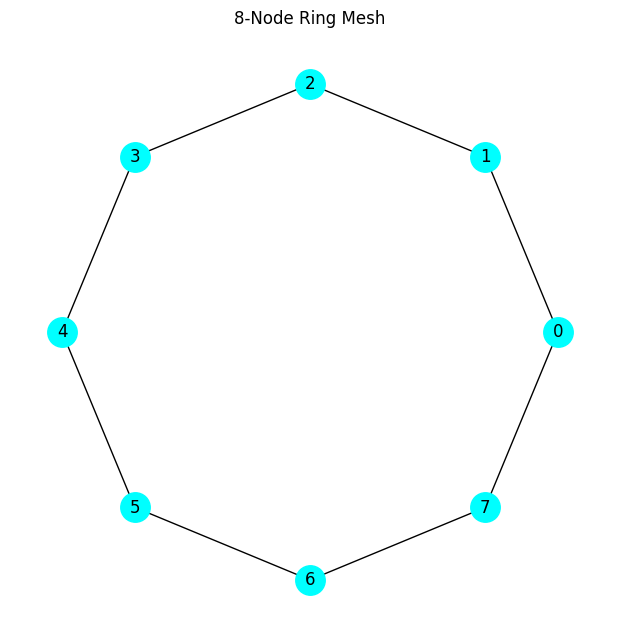

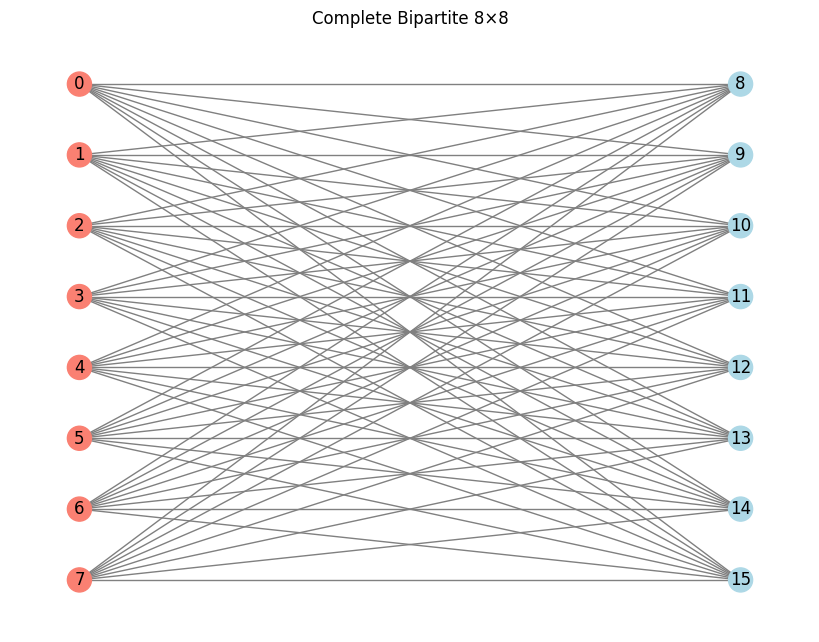

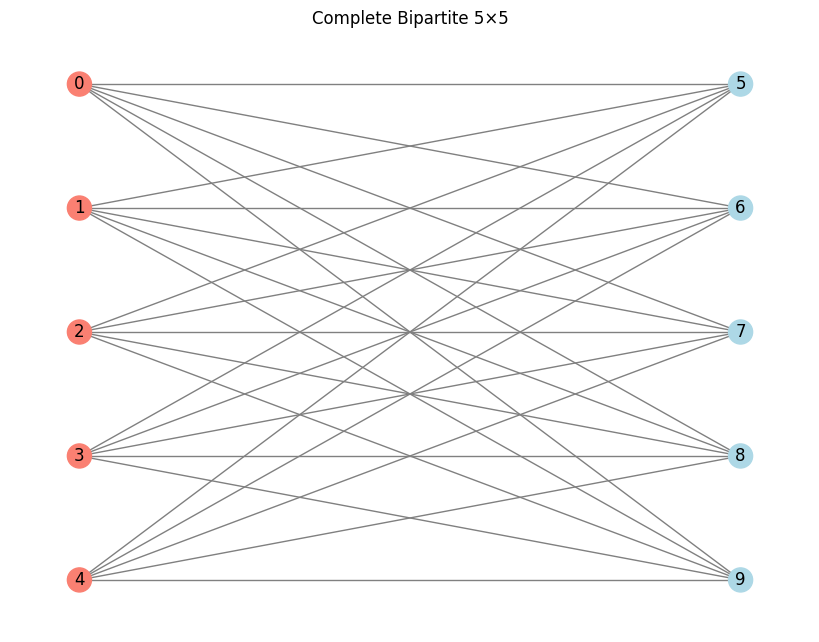

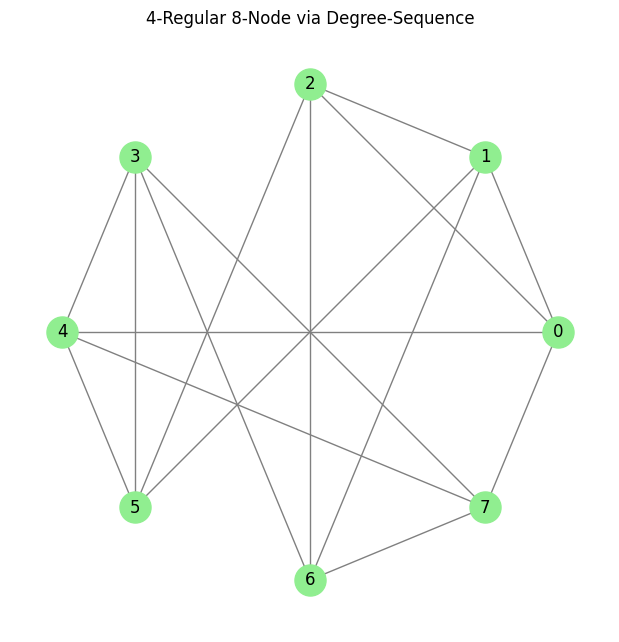

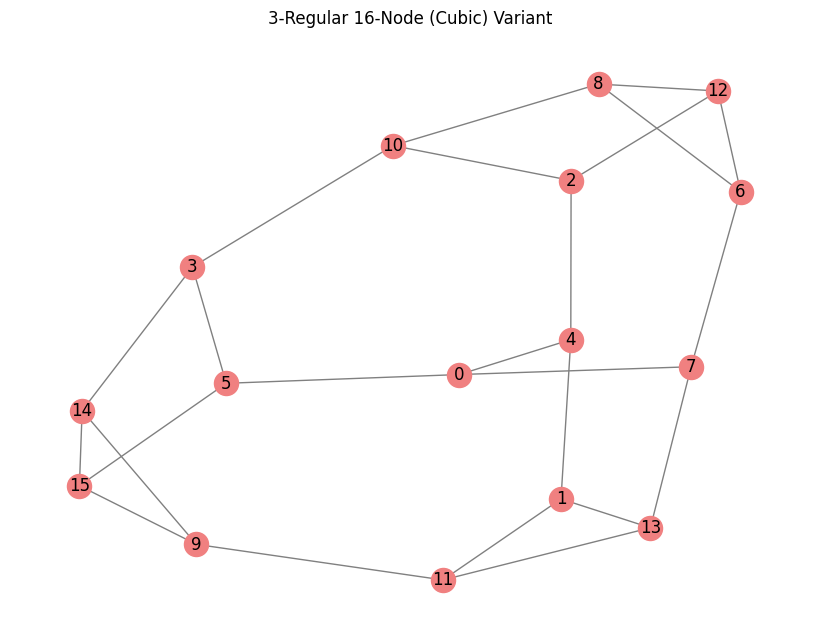

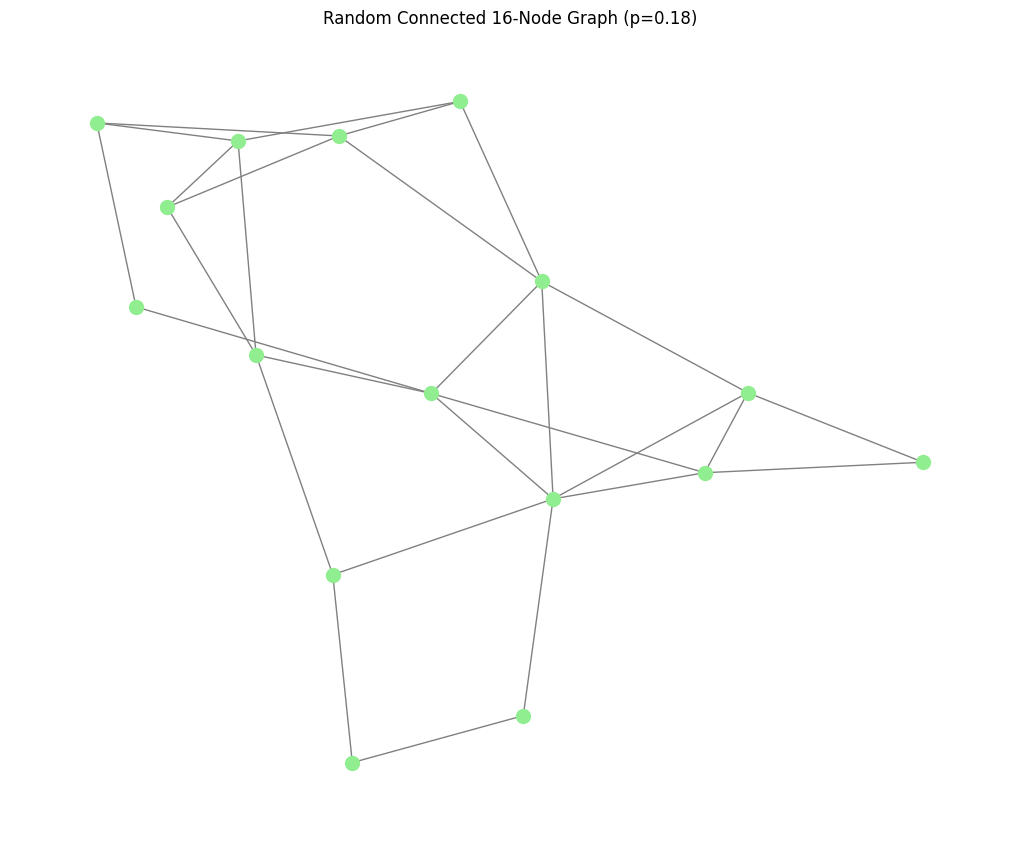

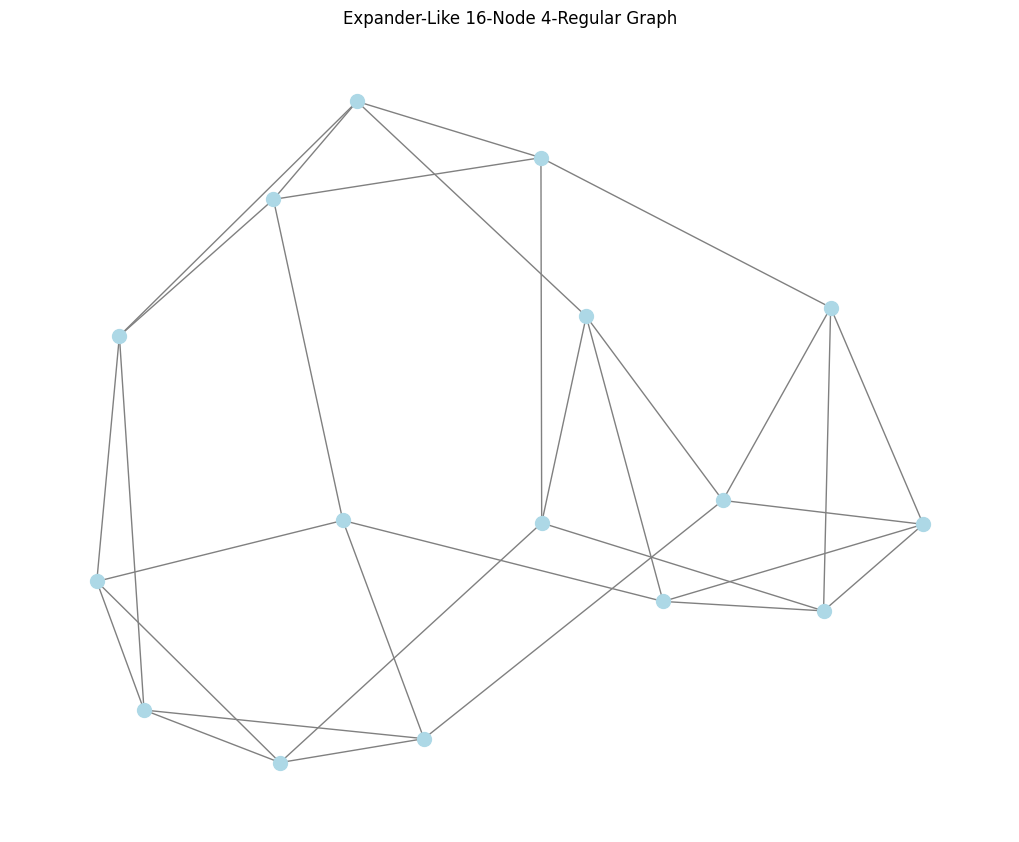

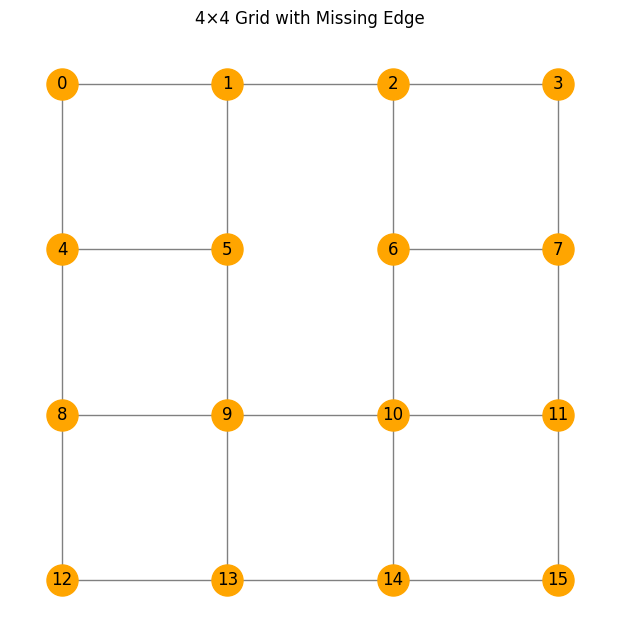

In [6]:
# Choose your favorite graph and build your winning ansatz!

graph1 = ring_mesh_8()
graph2 = bi_complete_8x8()
graph3 = bi_complete_nxn(5)
graph4 = reg_graph_8()
graph5 = cubic_graph_16()
graph6 = random_connected_graph_16(p=0.18)
graph7 = expander_graph_n(16)
graph8 = defective_grid_4x4()

# Input graph

In [8]:
graph = graph1
print(graph)

Graph with 8 nodes and 8 edges


Play around with all of them

# Crafting Your Quantum Ansatz

Our journey into solving MaxCut quantumly begins with the construction of a **parameterized quantum circuit (PQC)**, often referred to as an *ansatz*. This ansatz is tailored to the specific graph representing the MaxCut problem instance. The design of this circuit is a pivotal part of the challenge.

**Maximizing Your Impact: The Ansatz Optimization Challenge**
A core component of this hackathon revolves around your ingenuity in designing the `build_ansatz` function presented below. Your success and final score are directly linked to how effectively you can create an ansatz that is both:
* **Accurate:** Capable of finding the optimal MaxCut solution(s).
* **Efficient:** Achieves this accuracy with the minimum possible number of quantum gates. Future experiments and more complex problem instances will particularly benefit from highly optimized, low-gate-count circuits.

**Foundational Guidelines & Constraints:**

To ensure a fair and focused challenge, please adhere to the following set of rules. These are crucial for the evaluation process:

* **Function Signature:** The `build_ansatz` function must retain its original name and input/output structure. This is essential for our automated grading scripts.
* **Permitted Libraries:** You are encouraged to use the full power of **Qiskit**. However, the import of other external libraries is not permitted.
* **Self-Contained Algorithms:** If your ansatz design requires auxiliary classical logic (e.g., specific node ordering, graph traversal for gate placement), these algorithms must be implemented directly within the function or as helper functions within this notebook. Do not call external pre-written classical libraries for these tasks.
* **No Classical MaxCut Solvers:** This is a quantum hackathon! Critically, your `build_ansatz` function should construct a circuit that, when optimized, *finds* the MaxCut solution. Do **not** use a classical algorithm to determine the MaxCut solution beforehand and then simply encode that pre-determined answer into the quantum circuit parameters.
* **Gate Economy:** Strive for the most compact circuit possible. Minimizing the total gate count, especially two-qubit gates, is a key optimization goal.
* **Thorough Local Testing:** Before submitting, ensure your solution runs correctly for all the example graphs provided in this notebook.

**Reiterating for Clarity:**

This challenge empowers you to innovate within the defined scope of the `build_ansatz` function. Your toolkit is Qiskit. The objective is to design a quantum circuit whose parameters can be trained (using the varQITE method) to reveal the MaxCut solution. This means focusing on quantum strategies, not classical shortcuts. Your design should balance the quest for a minimal gate count with the ability to produce a high probability of measuring the correct MaxCut(s). Remember to meticulously gather and report your results for each graph.

**(Important Note: Submission and Documentation)**

To ensure your brilliant work is recognized and to confirm your results, please save this entire notebook, including all cell outputs (especially graphs and final scores). Upload the `.ipynb` file using the submission form: **[New Submission Link, if different, otherwise use the one from the previous cell]**.

**File Size Consideration:** To avoid issues with notebook upload limits (often around 10MB), please be judicious with the number and size of `print` statements. Large outputs can significantly inflate file size.

**Code Readability and Comments:** While you are free to modify the notebook to suit your experimentation, please ensure your final `build_ansatz` function (and any helper functions you write) are clean, readable, and **thoroughly commented**. We will be evaluating not just the performance of your solution but also your problem-solving approach and the clarity with which you explain your design choices. Your comments are a window into your thinking process!

Good luck with this exciting challenge, and may your circuits be efficient and your cuts maximal!


In [9]:
# Visualization will be performed in the cells below;

def build_ansatz(graph: nx.Graph) -> QuantumCircuit:

    ansatz = QuantumCircuit(graph.number_of_nodes())
    ansatz.h(range(graph.number_of_nodes()))

    theta = ParameterVector(r"$\theta$", graph.number_of_edges())
    for t, (u, v) in zip(theta, graph.edges):
        ansatz.cx(u, v)
        ansatz.ry(t, v)
        ansatz.cx(u, v)

    return ansatz

## On Parametrized Quantum Circuits

Parametrized quantum circuits (PQC) recently have gained significant attention as a prominent way to reach quantum advantage in many different fields. They are characterized by their use of varying parameters within quantum gates and can be optimized to solve specific problems, such as machine learning, quantum optimization, or quantum chemistry.

PQCs usually consist of three main parts:

1. Initialization: The qubits are set to a known starting state (usually $|0\rangle$) and then set into superposition with Hadamard gates.
2. Parameterized gates, such as rotation gates (Rx, Ry, Rz), and entanglement gates are adjustable.  Their parameters can be optimized to reflect the relationships between the encoded problem data.
3. Measurement: After applying the parameterized gates, the qubits are measured to get results.

These circuits are important elements in Variational Quantum Algorithms (VQA), hybrid quantum-classical systems where classical optimization helps to improve quantum operations. Two most notable examples of VQAs are Variational Quantum Eigensolver (VQE), an algorithm that finds a ground state energy of a given Hamiltonian, and Quantum Approximate Optimization Algorithm (QAOA), which is designed for solving combinatorial optimization problems. Near-term quantum computers are noisy and limited in size, and PQCs provide a practical way for us to use them more effectively.

More on that topic:
https://arxiv.org/abs/2207.06850

## Back to the problem in hand
This function produces parametrized quantum circuits (PQCs), a visualization of which is provided below.

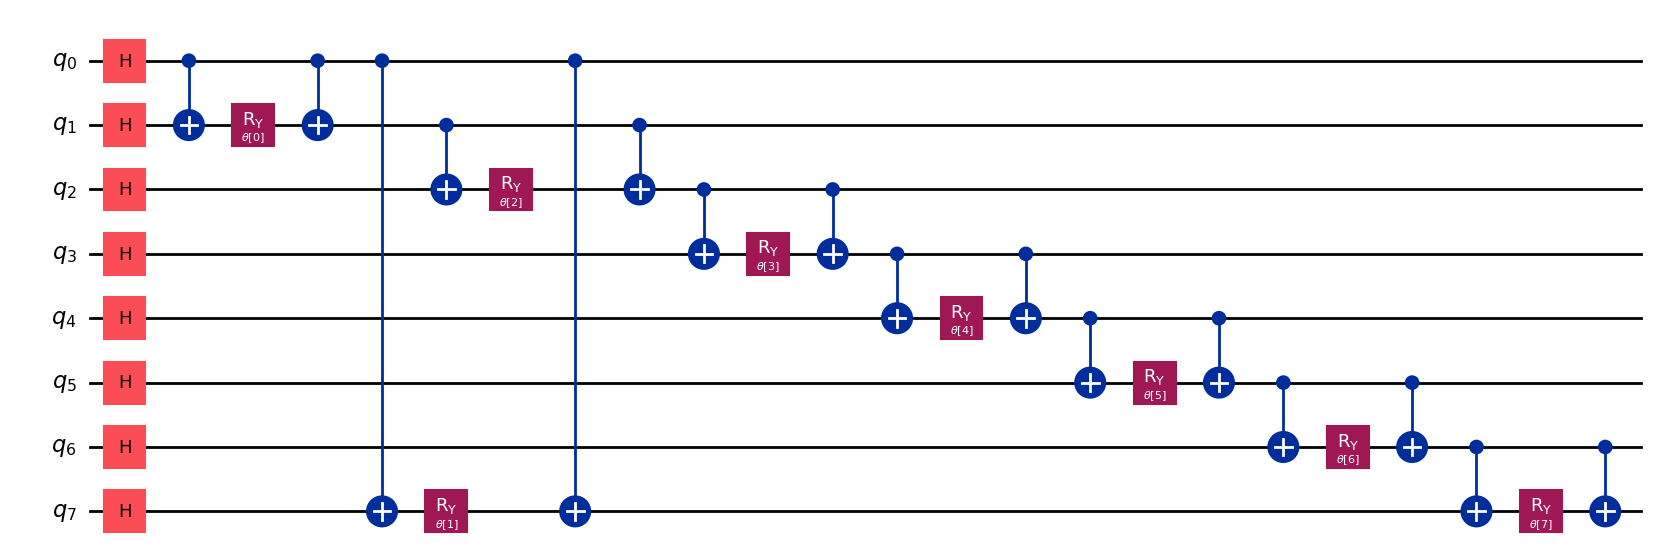

In [10]:
ansatz = build_ansatz(graph)
ansatz.draw("mpl", fold=-1)

# Building the MaxCut Hamiltonian

Formally, we write MaxCut as a [Quadratic Program (QP)][5] with binary
decision variables as follows. For each node $v \in V$, we let $x_v$ denote
a binary variable indicating whether $v$ belongs to $S$ or $T$. The objective
is to maximize the number of cut edges:
$$
    \text{maximize}_x\quad \sum_{(v, w) \in E} (x_v + x_w - 2 x_v x_w)
$$

Let's break this down. Notice that for each edge $e = (v, w)$ in the graph,
the quantity $(x_v + x_w - 2 x_v x_w)$ indicates whether $e$ is *cut* by the
partition represented by $x$; that is, the quantity $(x_v + x_w - 2 x_v x_w)$
is zero or one, and it equals one only if $v$ and $w$ lie on different sides of
the partition specified by $x$.

The code cell below obtains a symbolic representation of the maximization
objective corresponding to the graph above.

[5]: https://en.wikipedia.org/wiki/Quadratic_programming

In [11]:
 def build_maxcut_hamiltonian(graph: nx.Graph) -> SparsePauliOp:
    """
    Build the MaxCut Hamiltonian for the given graph H = (|E|/2)*I - (1/2)*Σ_{(i,j)∈E}(Z_i Z_j)
    """
    num_qubits = len(graph.nodes)
    edges = list(graph.edges())
    num_edges = len(edges)

    pauli_terms = ["I"*num_qubits] # start with identity
    coeffs = [-num_edges / 2]

    for (u, v) in edges: # for each edge, add -(1/2)*Z_i Z_j
        z_term = ["I"] * num_qubits
        z_term[u] = "Z"
        z_term[v] = "Z"
        pauli_terms.append("".join(z_term))
        coeffs.append(0.5)

    return SparsePauliOp.from_list(list(zip(pauli_terms, coeffs)))

Let's keep this function contained within its own cell, as you might need to adapt it for various max-cut problem types later.

In [12]:
ham = build_maxcut_hamiltonian(graph)
ham

SparsePauliOp(['IIIIIIII', 'ZZIIIIII', 'ZIIIIIIZ', 'IZZIIIII', 'IIZZIIII', 'IIIZZIII', 'IIIIZZII', 'IIIIIZZI', 'IIIIIIZZ'],
              coeffs=[-4. +0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,
  0.5+0.j,  0.5+0.j])

## As a Hamiltonian energy minimization problem
### Quantum MaxCut

Quantum computers are good at finding the ground state of particle systems
evolving under the action of a given Hamiltonian. In this section, we'll
construct a Hamiltonian whose energies are exactly the values of the MaxCut
objective function. This correspondence will effectively translate our
classical combinatorial optimization problem into a quantum problem, which
we'll approach using our novel heuristic.

Given an objective function $C(x)$, with domain $x \in \{0, 1\}^n$, we'll
produce a Hamiltonian $H_C$ on $n$ qubits such that
$$
    H_C \ket{x} = C(x) \ket{x}.
$$
In the last equation, $\ket{x}$ denotes the $n$-qubit
[computational basis][10] state indexed by the bit-string $x \in \{0, 1\}$.
Thus the last equation says each of the $2^n$ computational basis states is an
eigenvector of $H_C$, and the eigenvalue corresponding to $\ket{x}$ is $C(x)$;
that is, $H_C$ is diagonal with respect to the computational basis, and its
energies are the values of the objective function $C$.

We'll obtain the Hamiltonian $H_C$ by replacing each $x_j$ in the expression of
$C(x)$ by the operator
$$
    \hat{X}_j \coloneqq \frac{1}{2}(I - Z_j),
$$
where $I$ denotes the identity operator on $n$ qubits and $Z_j$ denotes the
[Pauli-Z][11] operator acting on the $j$th qubit. Notice that $\hat{X}_j$ is
diagonal with respect to the computational basis, and its eigenvalues are zero
and one; in particular,
$$
    \hat{X}_j \ket{x} = x_j \ket{x}.
$$

### MaxCut Hamiltonian

When we apply the Ising map construction to the MaxCut objective
$$
    M(x) = \sum_{(v, w) \in E} (x_v + x_w - 2 x_v x_w)
$$
we obtain the Hamiltonian
$$
    H_M = \sum_{(v, w) \in E} (X_v + X_w - 2 X_v X_w)
    = \frac{1}{2} \sum_{(v, w) \in E} \big(2 I - Z_v - Z_w - (I - Z_v)(I - Z_w)\big)
    = \frac{1}{2}|E| - \frac{1}{2} \sum_{(v, w) \in E} Z_v Z_w.
$$
In the last equation, $|E|$ denotes the number of edges in the graph.


[10]: https://en.wikipedia.org/wiki/Qubit#Standard_representation
[11]: https://en.wikipedia.org/wiki/Pauli_matrices

## Energy minimization via QITE
### Enter varQITE

With the MaxCut Hamiltonian in hand, we can turn to minimizing its energy using
our [novel quantum-classical varQITE heuristic][1]. Much like any Variataional
Quantum Algorithm (VQA), our novel varQITE method provides a recipe for
iteratively updating the parameters in a variational quantum circuit to
minimize the expectation value of the MaxCut Hamiltonian, measured with respect
to the parametrized state.

A key novelty is that our varQITE algorithm does *not* rely on a classical
optimizer to update the circuit parameters; instead, it specifies an explicit
update rule based on the solution of a system linear Ordinary Differential
Equations (ODEs). The ODEs relate the gradient of the variational circuit
parameters to the expected value of certain operators related to the MaxCut
Hamiltonian, and they are derived from an [Ehrenfest Theorem][3] that applies
to [imaginary time evolution][4]. For details, see Equation (5) in our [varQITE
paper][1].

In any case, setting up the ODE system at each step of the algorithm requires
executing a batch of quantum circuits and running some post-processing to
evaluate the results.

The code cell below illustrates how to set up the variational ansatz
$\ket{\Psi(\theta)}$ introduced by our [varQITE paper][1] in Equation (2).
We'll set up the required circuits and the ODEs further down.

[1]: https://arxiv.org/abs/2404.16135
[2]: https://www.nature.com/articles/s42254-021-00348-9
[3]: https://en.wikipedia.org/wiki/Ehrenfest_theorem
[4]: https://en.wikipedia.org/wiki/Imaginary_time

Below is simplified version of Quantum Imaginary Time Evolution (QITE). It uses a finite differences approach to estimate gradients, then performs gradient descent updates.

In [13]:
class QITEvolver:
    """
    A class to evolve a parametrized quantum state under the action of an Ising
    Hamiltonian according to the variational Quantum Imaginary Time Evolution
    (QITE) principle described in IonQ's latest joint paper with ORNL.
    """
    def __init__(self, hamiltonian: SparsePauliOp, ansatz: QuantumCircuit):
        self.hamiltonian = hamiltonian
        self.ansatz = ansatz

        # Define some constants
        self.backend = AerSimulator()
        self.num_shots = 10000
        self.energies, self.param_vals, self.runtime = list(), list(), list()

    def evolve(self, num_steps: int, lr: float = 0.4, verbose: bool = True):
        """
        Evolve the variational quantum state encoded by ``self.ansatz`` under
        the action of ``self.hamiltonian`` according to varQITE.
        """
        curr_params = np.zeros(self.ansatz.num_parameters)
        for k in range(num_steps):
            # Get circuits and measure on backend
            iter_qc = self.get_iteration_circuits(curr_params)
            job = self.backend.run(iter_qc, shots=self.num_shots)
            q0 = time.time()
            measurements = job.result().get_counts()
            quantum_exec_time = time.time() - q0

            # Update parameters-- set up defining ODE and step forward
            Gmat, dvec, curr_energy = self.get_defining_ode(measurements)
            dcurr_params = np.linalg.lstsq(Gmat, dvec, rcond=1e-2)[0]
            curr_params += lr * dcurr_params

            # Progress checkpoint!
            if verbose:
                self.print_status(measurements)
            self.energies.append(curr_energy)
            self.param_vals.append(curr_params.copy())
            self.runtime.append(quantum_exec_time)

    def get_defining_ode(self, measurements: List[dict[str, int]]):
        """
        Construct the dynamics matrix and load vector defining the varQITE
        iteration.
        """
        # Load sampled bitstrings and corresponding frequencies into NumPy arrays
        dtype = np.dtype([("states", int, (self.ansatz.num_qubits,)), ("counts", "f")])
        measurements = [np.fromiter(map(lambda kv: (list(kv[0]), kv[1]), res.items()), dtype) for res in measurements]

        # Set up the dynamics matrix by computing the gradient of each Pauli word
        # with respect to each parameter in the ansatz using the parameter-shift rule
        pauli_terms = [SparsePauliOp(op) for op, _ in self.hamiltonian.label_iter() if set(op) != set("I")]
        Gmat = np.zeros((len(pauli_terms), self.ansatz.num_parameters))
        for i, pauli_word in enumerate(pauli_terms):
            for j, jth_pair in enumerate(zip(measurements[1::2], measurements[2::2])):
                for pm, pm_shift in enumerate(jth_pair):
                    Gmat[i, j] += (-1)**pm * expected_energy(pauli_word, pm_shift)

        # Set up the load vector
        curr_energy = expected_energy(self.hamiltonian, measurements[0])
        dvec = np.zeros(len(pauli_terms))
        for i, pauli_word in enumerate(pauli_terms):
            rhs_op_energies = get_ising_energies(pauli_word, measurements[0]["states"])
            rhs_op_energies *= get_ising_energies(self.hamiltonian, measurements[0]["states"]) - curr_energy
            dvec[i] = -np.dot(rhs_op_energies, measurements[0]["counts"]) / self.num_shots
        return Gmat, dvec, curr_energy

    def get_iteration_circuits(self, curr_params: np.array):
        """
        Get the bound circuits that need to be evaluated to step forward
        according to QITE.
        """
        # Use this circuit to estimate your Hamiltonian's expected value
        circuits = [self.ansatz.assign_parameters(curr_params)]

        # Use these circuits to compute gradients
        for k in np.arange(curr_params.shape[0]):
            for j in range(2):
                pm_shift = curr_params.copy()
                pm_shift[k] += (-1)**j * np.pi/2
                circuits += [self.ansatz.assign_parameters(pm_shift)]

        # Add measurement gates and return
        [qc.measure_all() for qc in circuits]
        return circuits

    def plot_convergence(self):
        """
        Plot the convergence of the expected value of ``self.hamiltonian`` with
        respect to the (imaginary) time steps.
        """
        plt.plot(self.energies)
        plt.xlabel("(Imaginary) Time step")
        plt.ylabel("Hamiltonian energy")
        plt.title("Convergence of the expected energy")

    def print_status(self, measurements):
        """
        Print summary statistics describing a QITE run.
        """
        stats = pd.DataFrame({
            "curr_energy": self.energies,
            "num_circuits": [len(measurements)] * len(self.energies),
            "quantum_exec_time": self.runtime
        })
        stats.index.name = "step"
        display.clear_output(wait=True)
        display.display(stats)

A few utility functions:

In [14]:
def compute_cut_size(graph, bitstring):
    """
    Get the cut size of the partition of ``graph`` described by the given
    ``bitstring``.
    """
    cut_sz = 0
    for (u, v) in graph.edges:
        if bitstring[u] != bitstring[v]:
            cut_sz += 1
    return cut_sz

In [15]:
def get_ising_energies(
        operator: SparsePauliOp,
        states: np.array
    ):
    """
    Get the energies of the given Ising ``operator`` that correspond to the
    given ``states``.
    """
    # Unroll Hamiltonian data into NumPy arrays
    paulis = np.array([list(ops) for ops, _ in operator.label_iter()]) != "I"
    coeffs = operator.coeffs.real

    # Vectorized energies computation
    energies = (-1) ** (states @ paulis.T) @ coeffs
    return energies

In [16]:
def expected_energy(
        hamiltonian: SparsePauliOp,
        measurements: np.array
):
    """
    Compute the expected energy of the given ``hamiltonian`` with respect to
    the observed ``measurement``.

    The latter is assumed to by a NumPy records array with fields ``states``
    --describing the observed bit-strings as an integer array-- and ``counts``,
    describing the corresponding observed frequency of each state.
    """
    energies = get_ising_energies(hamiltonian, measurements["states"])
    return np.dot(energies, measurements["counts"]) / measurements["counts"].sum()

In [17]:
def interpret_solution(graph, bitstring):
    """
    Visualize the given ``bitstring`` as a partition of the given ``graph``.
    """
    pos = nx.spring_layout(graph, seed=42)
    set_0 = [i for i, b in enumerate(bitstring) if b == '0']
    set_1 = [i for i, b in enumerate(bitstring) if b == '1']

    plt.figure(figsize=(4, 4))
    nx.draw_networkx_nodes(graph, pos=pos, nodelist=set_0, node_color='blue', node_size=700)
    nx.draw_networkx_nodes(graph, pos=pos, nodelist=set_1, node_color='red', node_size=700)

    cut_edges = []
    non_cut_edges = []
    for (u, v) in graph.edges:
        if bitstring[u] != bitstring[v]:
            cut_edges.append((u, v))
        else:
            non_cut_edges.append((u, v))

    nx.draw_networkx_edges(graph, pos=pos, edgelist=non_cut_edges, edge_color='gray', width=2)
    nx.draw_networkx_edges(graph, pos=pos, edgelist=cut_edges, edge_color='green', width=2, style='dashed')

    nx.draw_networkx_labels(graph, pos=pos, font_color='white', font_weight='bold')
    plt.axis('off')
    plt.show()

,curr_energy,num_circuits,quantum_exec_time
step,,,
0,-3.9884,17,0.512980
1,-4.1024,17,0.485767
2,-4.1728,17,0.503784
3,-4.3180,17,0.484189
4,-4.3934,17,0.496818
5,-4.4924,17,0.513364
6,-4.5952,17,0.493044
7,-4.7200,17,0.520909
8,-4.8034,17,0.499135


CPU times: user 41 s, sys: 195 ms, total: 41.2 s
Wall time: 24.8 s


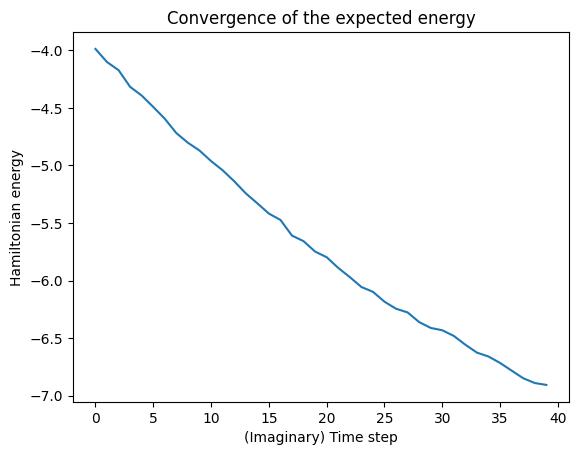

In [18]:
%%time

# Set up your QITEvolver and evolve!
qit_evolver = QITEvolver(ham, ansatz)
qit_evolver.evolve(num_steps=40, lr=0.1, verbose=True) # lr was 0.5

# Visualize your results!
qit_evolver.plot_convergence()

# Check out your best / most frequent cut!
Following the variational quantum imaginary time evolution (vQITE) loop, we sample the quantum circuit to obtain classical bitstrings.  The most frequent bitstring represents our solution, the final score though will take into account all of the right solutions...

In [19]:
from qiskit_aer import AerSimulator

shots = 100_000

# Sample your optimized quantum state using Aer
backend = AerSimulator()
optimized_state = ansatz.assign_parameters(qit_evolver.param_vals[-1])
optimized_state.measure_all()
counts = backend.run(optimized_state, shots=shots).result().get_counts()

# Find the sampled bitstring with the largest cut value
cut_vals = sorted(((bs, compute_cut_size(graph, bs)) for bs in counts), key=lambda t: t[1])
best_bs = cut_vals[-1][0]

# Now find the most likely MaxCut solution as sampled from your optimized state
# We'll leave this part up to you!!!
most_likely_soln = ""

print(counts)

{'00010010': 2, '11000101': 4, '00101110': 1, '11011101': 1, '11011011': 1, '01111100': 1, '11001101': 1, '00000011': 1, '11011001': 1, '11010111': 1, '00110110': 2, '00000111': 1, '11010001': 3, '00001010': 4, '11101001': 2, '11010011': 1, '11000000': 1, '01111011': 3, '11001011': 6, '01000010': 19, '01000111': 4, '01110111': 3, '01101111': 5, '01001111': 2, '01110011': 4, '10000100': 3, '01000011': 5, '00111010': 3, '11101101': 4, '10000110': 4, '00100110': 2, '00010001': 17, '01111001': 3, '11101000': 21, '00001101': 19, '01000100': 17, '10110001': 16, '00010100': 4, '10011110': 3, '10001100': 6, '11000010': 14, '10011100': 6, '11100010': 20, '11110101': 3, '00101000': 3, '10110011': 14, '11100100': 17, '00110111': 29, '11010110': 1469, '11101011': 1, '10101110': 346, '01100010': 26, '01001011': 335, '11000100': 22, '01101001': 387, '00110101': 1495, '10101101': 1439, '00111101': 24, '01101101': 364, '11011100': 26, '01010011': 356, '10100110': 353, '10001110': 8, '11101110': 24, '0

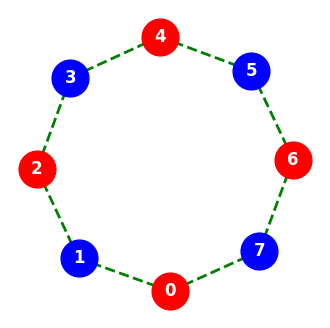

Cut value: 8
Graph with 8 nodes and 8 edges 10101010


In [20]:
interpret_solution(graph, best_bs)
print("Cut value: "+str(compute_cut_size(graph, best_bs)))
print(graph, best_bs)

# Drumroll please... the scores!


In [22]:
# Brute-force approach with conditional checks

################## Scoring ##################
G = graph
n = len(G.nodes())
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = 1.0

best_cost_brute = 0

for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]

    # Create subgraphs based on the partition
    subgraph0 = G.subgraph([i for i, val in enumerate(x) if val == 0])
    subgraph1 = G.subgraph([i for i, val in enumerate(x) if val == 1])

    bs = "".join(str(i) for i in x)

    # Check if subgraphs are not empty
    if len(subgraph0.nodes) > 0 and len(subgraph1.nodes) > 0:
        cost = 0
        for i in range(n):
            for j in range(n):
                cost = cost + w[i, j] * x[i] * (1 - x[j])
        if best_cost_brute < cost:
            best_cost_brute = cost
            xbest_brute = x
            XS_brut = []
        if best_cost_brute == cost:
            XS_brut.append(bs)

print("Best bitstrings: " + str(XS_brut))

def final_score(graph, optimal_bitstrings, counts, shots, ansatz):

    num_qubits = graph.number_of_nodes()
    inaccuracy, accuracy_score = 0, 0.0

    target_solutions = optimal_bitstrings
    # ensure optimal_bitstrings have the correct length
    optimal_bitstrings_formatted = [bs.zfill(num_qubits) for bs in target_solutions]

    theoretical_amplitude = int(shots/len(optimal_bitstrings_formatted))
    for bitstring in optimal_bitstrings_formatted:
        if bitstring in counts:
            inaccuracy += abs(counts[bitstring]-theoretical_amplitude)
        else:
            inaccuracy += theoretical_amplitude

    accuracy_score = 1.0 - inaccuracy/shots

    # CNOT count penalty
    try:
        transpiled_ansatz = transpile(ansatz, basis_gates=['cx', 'rz', 'sx', 'x'])
        ops_count = transpiled_ansatz.count_ops()
        cx_count = ops_count.get('cx', 0)
    except Exception as e:
        print(f"Error during transpilation or counting ops: {e}")
        logging.error(f"Error during transpilation or counting ops: {e}")
        cx_count = float('inf')

    num_edges = graph.number_of_edges()
    denominator = (8 * num_edges + cx_count)
    if denominator == 0 :
        efficiency_score = 1.0
    else:
        efficiency_score = (8 * num_edges) / denominator


    score = efficiency_score * accuracy_score

    return np.round(score, 5)

print("Final score: " + str(final_score(graph, XS_brut, counts, shots, ansatz)))

Best bitstrings: ['10101010', '01010101']
Final score: 0.4053


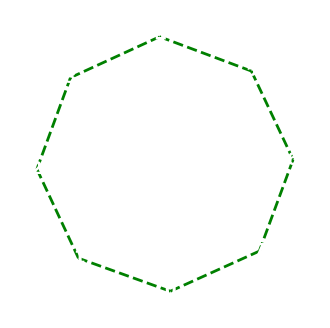

Graph with 8 nodes and 8 edges [1, 0, 1, 0, 1, 0, 1, 0]

Best solution = [1, 0, 1, 0, 1, 0, 1, 0] cost = 8.0
['10101010', '01010101']


In [23]:
# This is classical brute force solver results:
interpret_solution(graph, xbest_brute)
print(graph, xbest_brute)
print("\nBest solution = " + str(xbest_brute) + " cost = " + str(best_cost_brute))
print(XS_brut)

plt.show()

In [25]:
# Total number of correct shots, but we do not check if they are balanced (equiprobable)

sum_counts = 0
for bs in counts:
    if bs in XS_brut:
        sum_counts += counts[bs]

print(f"Max-cut: {sum_counts} out of {shots}")

Max-cut: 50662 out of 100000


In [26]:
# additional function for error calculation
def calculate_sse(counts, shots, optimal_bitstrings, num_qubits):
    """
    Calculates the Sum of Squared Errors between the measured distribution
    and the ideal uniform distribution over optimal solutions.
    """
    if not optimal_bitstrings:
        print("No optimal bitstrings provided for SSE calculation.")
        return 1.0

    num_optimal = len(optimal_bitstrings)
    if num_optimal == 0:
        print("Zero optimal bitstrings provided.")
        return 1.0

    ideal_prob = 1.0 / num_optimal
    sse = 0.0

    ideal_dist = {format(i, f'0{num_qubits}b'): 0.0 for i in range(2**num_qubits)}
    for bs in optimal_bitstrings:
        formatted_bs = bs.zfill(num_qubits)
        if len(formatted_bs) == num_qubits:
            ideal_dist[formatted_bs] = ideal_prob
        else:
            print(f"Optimal bitstring '{bs}' has incorrect length after formatting. Expected {num_qubits}.")


    measured_total_prob = 0.0
    for i in range(2**num_qubits):
        bitstring = format(i, f'0{num_qubits}b')
        measured_prob = counts.get(bitstring, 0) / shots
        measured_total_prob += measured_prob
        ideal_p = ideal_dist.get(bitstring, 0.0)
        sse += (measured_prob - ideal_p)**2

    # if not math.isclose(measured_total_prob, 1.0, abs_tol=1e-5):
    #     print(f"Sum of measured probabilities ({measured_total_prob}) is not close to 1.")

    return sse

This is the main challenge:  design optimal ansatz generators and Hamiltonians for the max-cut problem. You can also modify the implementation of varQITE and corresponding hyper-paramebers: number of iterative steps and learning rate.

You can experiment with your solution here and then transfer the code modifications into Submit notebook. Follow the instructions there to pass your source code to the auto-grader evaluation

*Good Luck!!! And have FUN!!!*



---

